<a href="https://www.kaggle.com/code/lasseschulz/uci-heart-disease-prediction-data-analytics-hwr?scriptVersionId=249119149" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Heart Disease Classification
**Machine Learning for Heart Disease Prediction**

Dataset: [UCI Heart Disease Dataset](https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data)  
Student: Lasse Schulz   

### Business Understanding
**Goal:** Classification of patients based on heart disease presence.

Heart disease is one of the leading causes of death worldwide. Early detection and accurate diagnosis are crucial for effective treatment and prevention. Machine learning can help healthcare professionals identify patients at risk of heart disease by analyzing various medical indicators and patient characteristics. In this notebook, we will explore the capabilities of machine learning algorithms to classify patients as having heart disease or not, using the UCI Heart Disease dataset.


### Project Context
This project (tries to) follow the CRISP-DM methodology for data science projects. We will analyze patient data including age, sex, chest pain type, blood pressure, cholesterol levels, and other medical indicators to predict the presence of heart disease. The goal is to build a reliable classification model that can assist healthcare professionals in the prediction of heart diseases.

## Dataset Overview
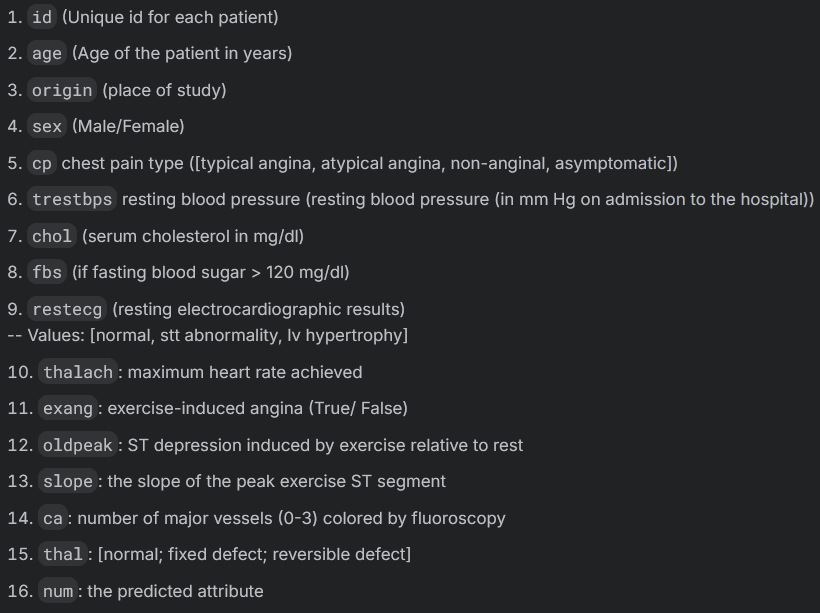

> (*source*: https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data)


# 1. Data

## 1.1 General imports and reading the dataset

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings

# Core machine learning imports
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Enable experimental features first, then import
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV



# print versions for future reference
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"sklearn version: {sklearn.__version__}")
print(f"seaborn version: {sns.__version__}\n")

#remove futurewarnings for better work environment (AI Disclaimer)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, message='.*FixedFormatter.*')

# set pandas and matplotlib options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.rcParams["figure.figsize"] = (12, 8)



# read the heart disease dataset and show head
df = pd.read_csv('/kaggle/input/heart-disease-data/heart_disease_uci.csv')

numpy version: 1.26.4
pandas version: 2.2.3
sklearn version: 1.2.2
seaborn version: 0.12.2



# 2. Exploratory Data Analysis

The dataset info reveals important structural characteristics of our heart disease dataset. We now have 920 patient records with 16 columns total, where 15 columns represent features and 1 column (num) serves as our target variable. The dataset contains a mix of data types including 3 integer columns, 5 float columns for continuous measurements, and 8 object columns representing categorical variables. 

## 2.1 Description of the data set

In [2]:
# data overview
# basic info
print(f"shape: {df.shape}")
print(f"samples: {df.shape[0]}")
print(f"features: {df.shape[1]}")

# missing values
missing = df.isnull().sum().sum()
print(f"\nmissing values: {missing}")


shape: (920, 16)
samples: 920
features: 16

missing values: 1759


## 2.2 Data visualization

In [3]:
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


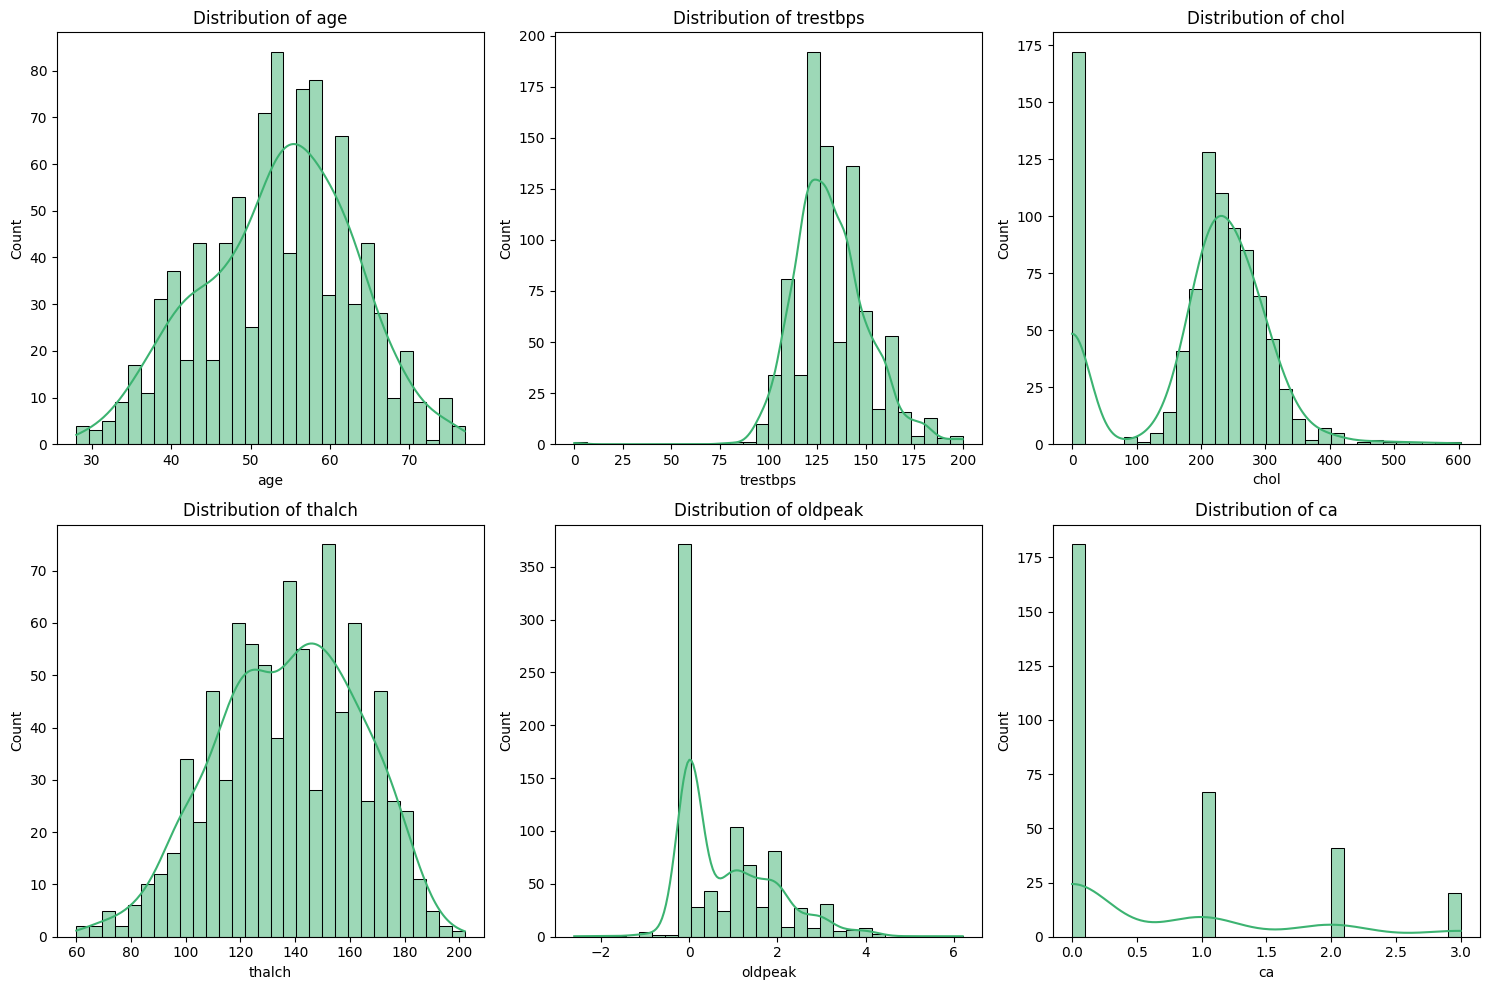

In [4]:
# distribution of numerical columns
numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=30, color='mediumseagreen')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

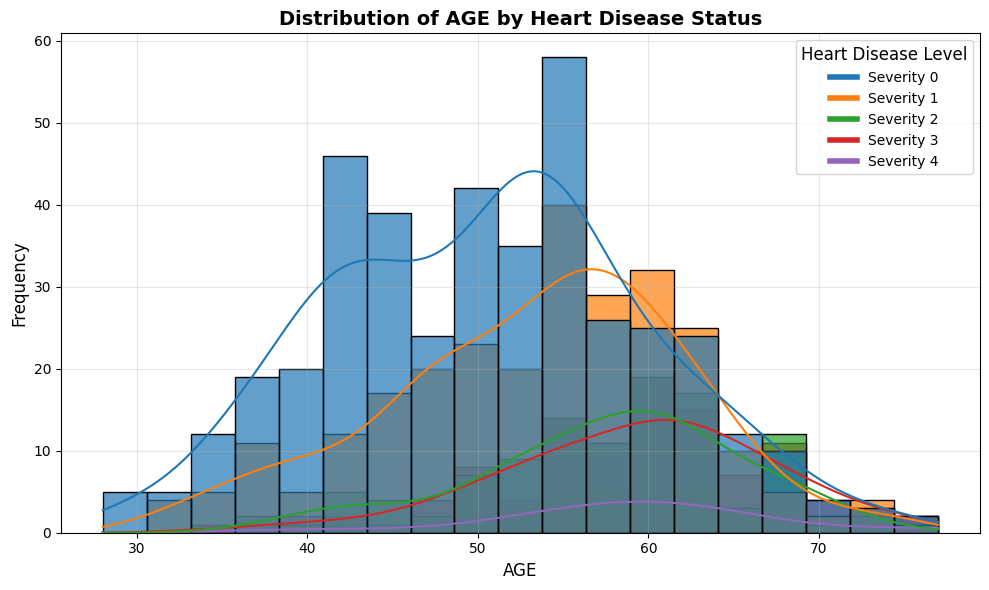

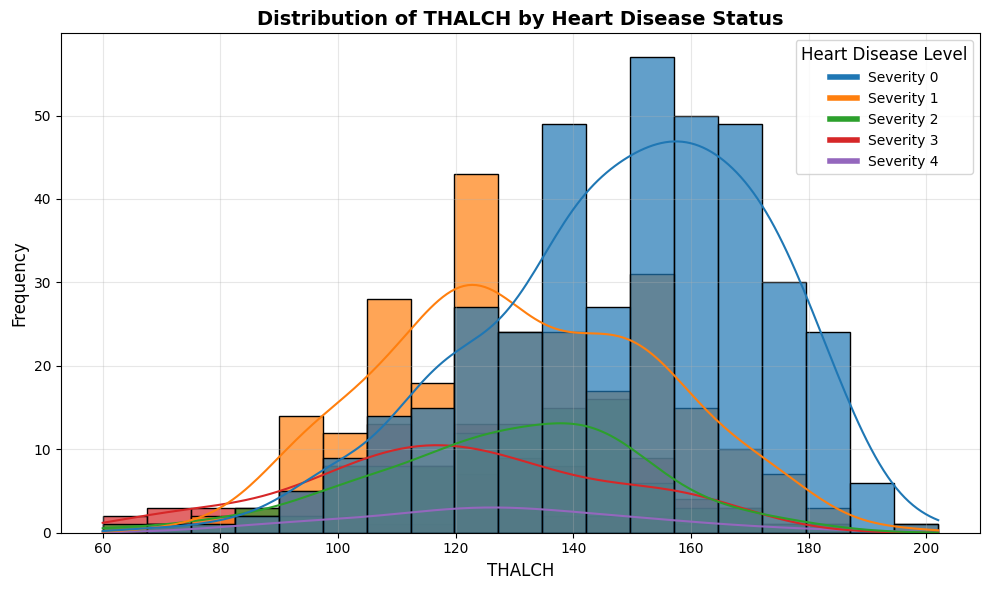

In [5]:
# (AI generated color palette)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Distinct colors for each class
palette = sns.color_palette(colors[:len(df['num'].unique())])

for cols in df[['age','thalch']]:
    plt.figure(figsize=(10, 6))
    
    # Create the histogram plot
    sns.histplot(data=df, x=cols, hue='num', kde=True, palette=palette, alpha=0.7)
    
    plt.title(f'Distribution of {cols.upper()} by Heart Disease Status', fontsize=14, fontweight='bold')
    plt.xlabel(cols.upper(), fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    
    # Create custom legend with all heart disease levels
    unique_levels = sorted(df['num'].unique())
    legend_elements = []
    
    for i, level in enumerate(unique_levels):
        legend_elements.append(plt.Line2D([0], [0], color=colors[i], lw=4, label=f'Severity {int(level)}'))
    
    plt.legend(handles=legend_elements, title='Heart Disease Level', title_fontsize=12, fontsize=10)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

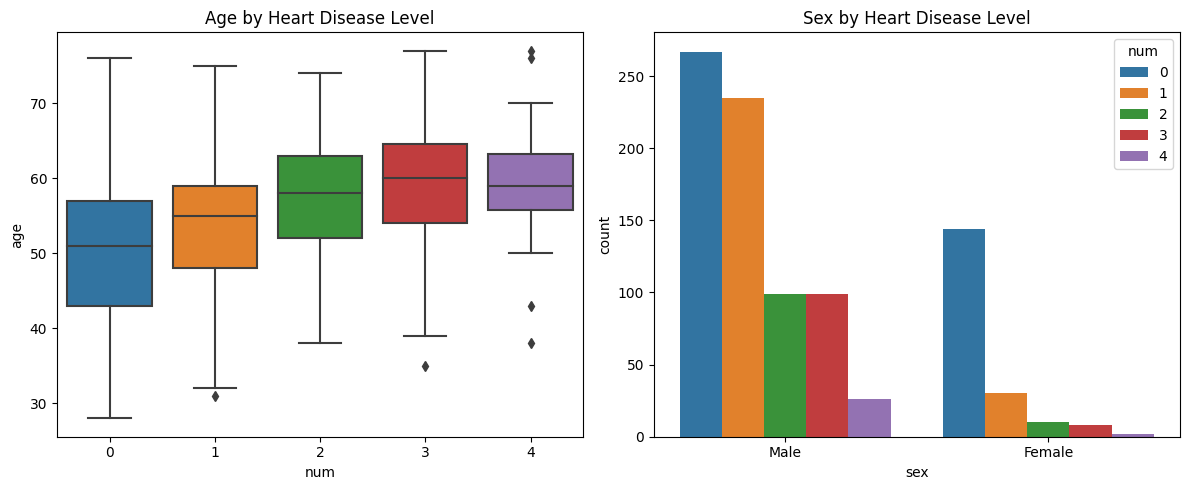

In [6]:
# Age by heart disease level
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='num', y='age')
plt.title('Age by Heart Disease Level')

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='sex', hue='num')
plt.title('Sex by Heart Disease Level')
plt.xticks([0, 1], ['Male', 'Female'])



plt.tight_layout()
plt.show()

In [7]:
df['exang'].value_counts()

exang
False    528
True     337
Name: count, dtype: int64

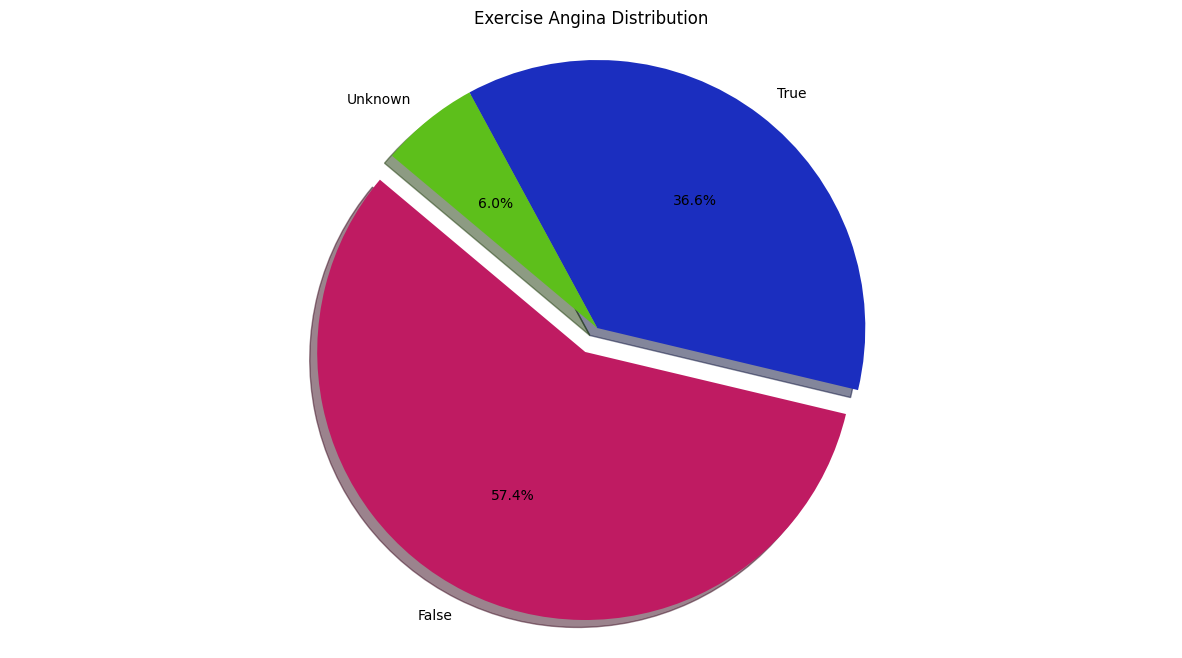

In [8]:
labels = ['False','True','Unknown']
sizes = [528,337,55]
colors = ['#bf1b62','#1b2ebf','#5dbf1b']
explode = (0.1,0,0) 
plt.figure(figsize=(15, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Exercise Angina Distribution')
plt.axis('equal')
plt.show()

In [9]:
df['cp'].value_counts()

cp
asymptomatic       496
non-anginal        204
atypical angina    174
typical angina      46
Name: count, dtype: int64

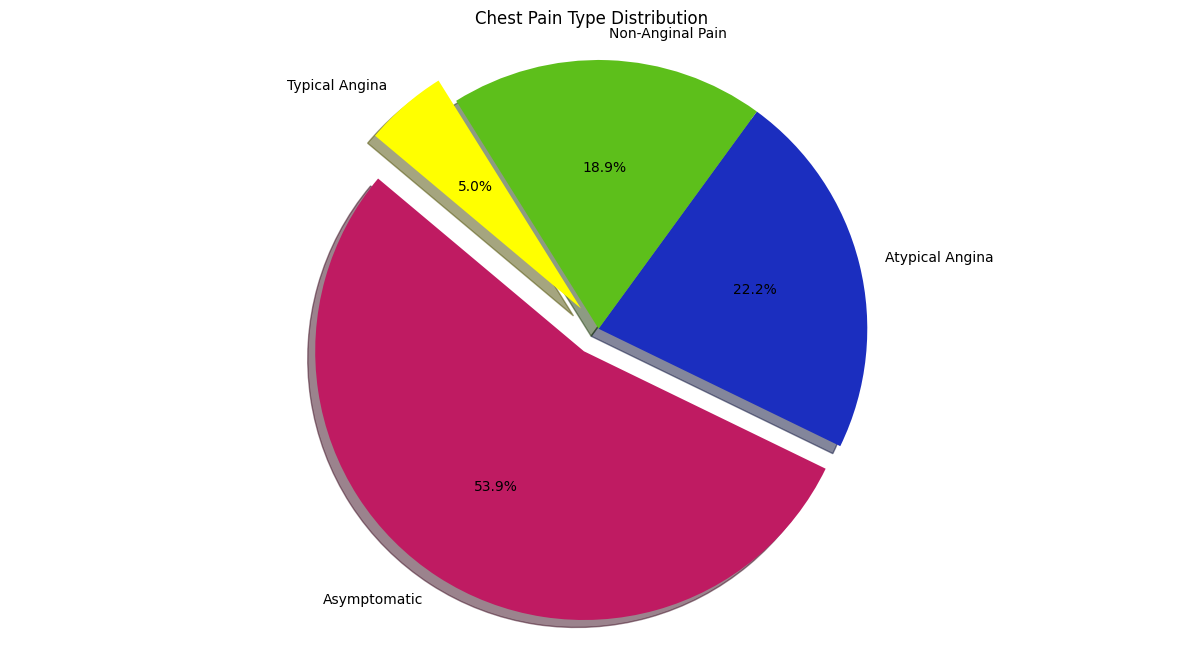

In [10]:
labels = ['Asymptomatic','Atypical Angina','Non-Anginal Pain', 'Typical Angina']
sizes = [496,204,174,46]
colors = ['#bf1b62','#1b2ebf','#5dbf1b', '#ffff00']
explode = (0.1,0,0, 0.1) 
plt.figure(figsize=(15, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Chest Pain Type Distribution')
plt.axis('equal')
plt.show()

## 2.3 Analysis of missing data

In [11]:
# check for missing values
print("missing values:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing Count': missing_values.values,
    'Missing Percentage': missing_percentage.values
})

# only show columns with missing values
missing_df = missing_df[missing_df['Missing Count'] > 0]

if len(missing_df) > 0:
    display(missing_df)

missing values:


,Column,Missing Count,Missing Percentage
5,trestbps,59,6.413043
6,chol,30,3.260870
7,fbs,90,9.782609
8,restecg,2,0.217391
9,thalch,55,5.978261
10,exang,55,5.978261
11,oldpeak,62,6.739130
12,slope,309,33.586957
13,ca,611,66.413043
14,thal,486,52.826087


# 3. Data Preparation
Now we'll prepare the data for machine learning by handling any data quality issues and feature engineering. 
We will use the entire dataset with filtering to maintain the clarity. We aim to preserve as much valuable patient data as possible by implementing strategic imputation techniques rather than simply removing incomplete records, which is crucial in medical datasets where each patient record represents valuable clinical information that could improve our model's ability to detect heart disease patterns.

In [12]:
df.drop(columns=['id','dataset'],inplace=True)

## 3.1 Data Transformation

In [13]:
# applying amputations to dataset columns
df['trestbps'].fillna(df['trestbps'].mean(),inplace=True)
df['chol'].fillna(df['chol'].mean(),inplace=True)
df['thalch'].fillna(df['thalch'].mean(),inplace=True)
df['ca'].fillna(df['ca'].mean(), inplace=True)

df['oldpeak'].fillna(df['oldpeak'].mean(), inplace=True)
df.loc[df['oldpeak'] < 0, 'oldpeak'] = 0

df['restecg'].fillna(df['restecg'].mode()[0], inplace=True)


# fill NaNs with 'Unknown' in category columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns
df[cat_cols] = df[cat_cols].fillna('Unknown')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   cp        920 non-null    object 
 3   trestbps  920 non-null    float64
 4   chol      920 non-null    float64
 5   fbs       920 non-null    object 
 6   restecg   920 non-null    object 
 7   thalch    920 non-null    float64
 8   exang     920 non-null    object 
 9   oldpeak   920 non-null    float64
 10  slope     920 non-null    object 
 11  ca        920 non-null    float64
 12  thal      920 non-null    object 
 13  num       920 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 100.8+ KB


Applying Imputations to Numerical & Categorical Columns

In [15]:
# Convert categorical columns to numerical
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    if col in df.columns:
        # Get unique values and create mapping
        unique_values = df[col].unique()
        mapping = {value: i for i, value in enumerate(unique_values)}
        
        # Apply mapping
        df[col] = df[col].map(mapping)
        
        print(f"Converted {col}: {mapping}")


df.head()

Converted sex: {'Male': 0, 'Female': 1}
Converted cp: {'typical angina': 0, 'asymptomatic': 1, 'non-anginal': 2, 'atypical angina': 3}
Converted fbs: {True: 0, False: 1, 'Unknown': 2}
Converted restecg: {'lv hypertrophy': 0, 'normal': 1, 'st-t abnormality': 2}
Converted exang: {False: 0, True: 1, 'Unknown': 2}
Converted slope: {'downsloping': 0, 'flat': 1, 'upsloping': 2, 'Unknown': 3}
Converted thal: {'fixed defect': 0, 'normal': 1, 'reversable defect': 2, 'Unknown': 3}


,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,0,0,145.0,233.0,0,0,150.0,0,2.3,0,0.0,0,0
1,67,0,1,160.0,286.0,1,0,108.0,1,1.5,1,3.0,1,2
2,67,0,1,120.0,229.0,1,0,129.0,1,2.6,1,2.0,2,1
3,37,0,2,130.0,250.0,1,1,187.0,0,3.5,0,0.0,1,0
4,41,1,3,130.0,204.0,1,0,172.0,0,1.4,2,0.0,1,0


In [16]:
# some statements were created with ChatGPT for debugging purposes and better overview in the presentation 
# source: https://www.youtube.com/watch?v=Bu0LoTZDgis&ab_channel=GabrielAtkin
# Identify categorical columns

def onehot_encode(df, column_dict):
    df = df.copy()
    for column, prefix in column_dict.items():
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [17]:
def preprocess_inputs(df, scaler):
    df = df.copy()
    
    # One-hot encode the nominal features
    nominal_features = ['cp', 'slope', 'thal']
    df = onehot_encode(df, dict(zip(nominal_features, ['CP', 'SL', 'TH'])))
    
    # Split df into X and y
    y = df['num'].copy()
    X = df.drop(['num'], axis=1).copy()
    
    # Scale X
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    return X, y

In [18]:
X, y = preprocess_inputs(df, RobustScaler())

In [19]:
X.head()

,age,sex,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,ca,CP_0,CP_1,CP_2,CP_3,SL_0,SL_1,SL_2,SL_3,TH_0,TH_1,TH_2,TH_3
0,0.692308,0.0,0.75,0.134454,-1.0,-1.0,0.333333,0.0,1.000000,-0.676375,1.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0
1,1.000000,0.0,1.50,0.728291,0.0,-1.0,-0.833333,1.0,0.466667,2.323625,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-1.0
2,1.000000,0.0,-0.50,0.089636,0.0,-1.0,-0.250000,1.0,1.200000,1.323625,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.0
3,-1.307692,0.0,0.00,0.324930,0.0,0.0,1.361111,0.0,1.800000,-0.676375,0.0,-1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0
4,-1.000000,1.0,0.00,-0.190476,0.0,-1.0,0.944444,0.0,0.400000,-0.676375,0.0,-1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-1.0


Our heart disease dataset is mostly made up of categories that need to be converted to numbers so they work with machine learning models. The categories need to be mapped to specific numbers using the right encoding techniques. For that we use the one-hot encoding method as it is the easiest and most effective encoding method for such a use case.

## 3.2 Medical Feature Selection

Our heart disease classification feature selection is based on well-established cardiovascular risk factors.

Age (age) is a critical predictor as cardiovascular disease risk doubles every 10 years after age 45. [Link](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(98)10279-9/fulltext)

Sex (sex) is an important demographic factor as males have approximately twice the heart disease risk of premenopausal women. [Link](https://pmc.ncbi.nlm.nih.gov/articles/PMC3018605/)

Chest pain type (CP) serves as the primary symptom indicator for coronary artery disease. [Link](https://www.ncbi.nlm.nih.gov/books/NBK564304/)

Resting blood pressure (TRESTBP) is a fundamental cardiovascular measurement. Values exceeding 140/90 mmHg increase heart disease risk. [Link](https://pmc.ncbi.nlm.nih.gov/articles/PMC10243231/)

Cholesterol levels (CHOL) represent a key metabolic risk factor. High cholesterol levels above 240 mg/dl approximately double the risk of heart disease. [Link](https://www.ncbi.nlm.nih.gov/books/NBK279318/)

Maximum heart rate achieved (THALACH) indicates cardiovascular fitness levels. [Link](https://austinpublishinggroup.com/austin-cardiology/fulltext/cardiology-v4-id1021.pdf)

Number of major vessels colored by fluoroscopy (ca) provides direct anatomical evidence of coronary artery blockage, with each blocked vessel increasing mortality risk by approximately 30%. [Link](https://www.ncbi.nlm.nih.gov/books/NBK459269/)

The selected features, when considered collectively, provide comprehensive coverage of the demographic risk factors, clinical symptoms, physiological measurements and diagnostic test results necessary for accurate heart disease diagnosis. At the end of the Notebook you can see, what features were important for the training of the model. Right now the named features are specifically important for real life application.


## 3.2 New Features: Binary Classification

In [20]:
# Convert target to binary classification (matching Shoaib Ahmed's approach)
# source: https://www.kaggle.com/code/shoaibahmedansari/heart-disease-analysis-and-classification
# 0 = no heart disease, 1 = heart disease present 
df['num_binary'] = (df['num'] > 0).astype(int)

print("Original target distribution:")
print(df['num'].value_counts().sort_index())
print("\nBinary target distribution:")
print(df['num_binary'].value_counts().sort_index())



Original target distribution:
num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

Binary target distribution:
num_binary
0    411
1    509
Name: count, dtype: int64


### Why Binary Classification?

The "num" column in the UCI Heart Disease dataset originally has values 0-4:
0 = no heart disease.
1, 2, 3, 4 are the different levels of heart disease.
For practical and testing reasons we will turn this into a  **binary classification problem**:
0 = no heart disease.
1 = Heart Disease present

## 3.3 Data Splitting

In [21]:
# Prepare features and binary target for heart disease prediction
# changed due to hot encoder X = df.drop(['num', 'num_binary'], axis=1)
y = df['num_binary']

# Perform stratified train-test split for medical data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  # 20% for testing, 80% for training
    random_state=42,
    stratify=y  # Maintain class distribution for medical data
)

# Display splitting results for heart disease classification - created with ai for debugging and simplicity
print(f"Training set size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"Total dataset size: {len(X)}")

Training set size: 736 (80.0%)
Test set size: 184 (20.0%)
Total dataset size: 920


# 4. Model Building
## 4.1 Random Forest


In [22]:
#ML training
start_fit = time.time()
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
end_fit = time.time()

print(f"Training time: {end_fit - start_fit:.2f} seconds")

start_pred = time.time()
y_pred_rf = rf.predict(X_test)
end_pred = time.time()
print(f"Prediction time: {end_pred - start_pred:.2f} seconds")

Training time: 0.19 seconds
Prediction time: 0.01 seconds


In [23]:
print("Random Forest CLassification Report")
print(classification_report(y_test, y_pred_rf, digits=4))
rf_report = classification_report(y_test, y_pred_rf, digits=4, output_dict=True)

Random Forest CLassification Report
              precision    recall  f1-score   support

           0     0.8514    0.7683    0.8077        82
           1     0.8273    0.8922    0.8585       102

    accuracy                         0.8370       184
   macro avg     0.8393    0.8302    0.8331       184
weighted avg     0.8380    0.8370    0.8359       184



We can see that we've already got some good scores, but it's worth mentioning that the category with the least Support values (No Disease found) also has the lowest score. Nevertheless, the prediction gets a good score when predicting actual diseases found.

## 4.2 Random Forest - Confusion Matrix

[Stackoverflow source](https://stackoverflow.com/questions/61325314/how-to-change-plot-confusion-matrix-default-figure-size-in-sklearn-metrics-packa)

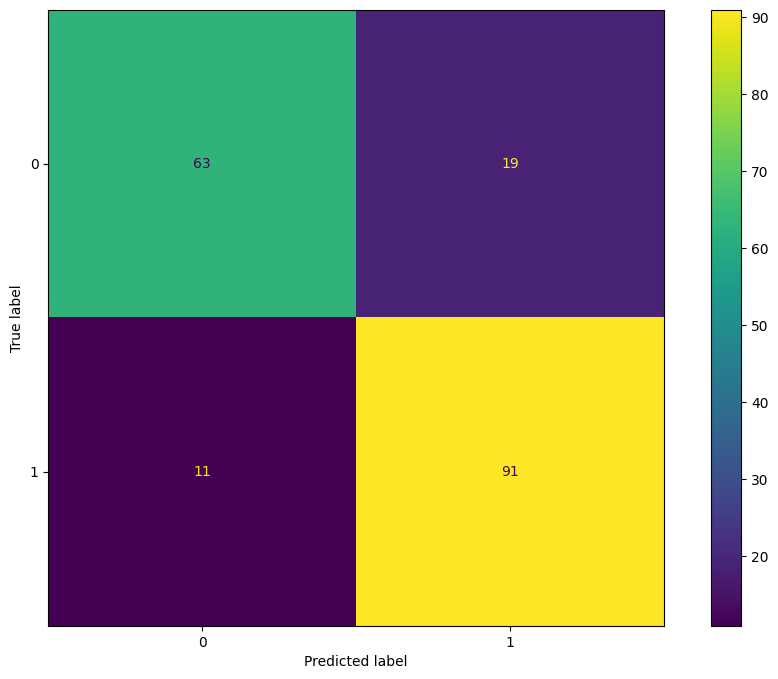

In [24]:
rf_confm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)

## 4.3 Random Forest Hyperparameter Tuning

We are working on a binary heart disease classification problem (0 = no heart disease, 1 = heart disease present). We will use [f1_macro](https://iamirmasoud.com/2022/06/19/understanding-micro-macro-and-weighted-averages-for-scikit-learn-metrics-in-multi-class-classification-with-example/) because Both classes are equally important in medical diagnosis
* False Negatives: Missing actual heart disease (dangerous)
* False Positives: Unnecessary worry/treatment (costly but safer)
* f1_macro treats both classes equally



In [25]:
# Hyperparemters were are tuning
params = {
    'n_estimators': [100, 200, 300],           # Number of trees (most important)
    'max_depth': [10, 15, 20, None],           # Tree depth (prevents overfitting)
    'min_samples_split': [2, 5, 10]           # Min samples to split (controls overfitting)
}

# This uses stratefiedKfold as a cross validation method 
# source https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html

rf_grid = HalvingGridSearchCV(
    rf,
    params,
    cv=5,
    scoring='f1_macro',
    verbose=1,
    return_train_score=True,
    n_jobs=-1
)
start_fit = time.time()
rf_grid.fit(X_train, y_train)

end_fit = time.time()
print(f"Training time: {end_fit - start_fit:.2f} seconds")

print("\nGrid Search Best Params:", rf_grid.best_params_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 27
max_resources_: 736
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 36
n_resources: 27
Fitting 5 folds for each of 36 candidates, totalling 180 fits
----------
iter: 1
n_candidates: 12
n_resources: 81
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 2
n_candidates: 4
n_resources: 243
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 729
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Training time: 37.74 seconds

Grid Search Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}


Prediction time: 0.02 seconds
              precision    recall  f1-score   support

           0     0.8442    0.7927    0.8176        82
           1     0.8411    0.8824    0.8612       102

    accuracy                         0.8424       184
   macro avg     0.8426    0.8375    0.8394       184
weighted avg     0.8425    0.8424    0.8418       184



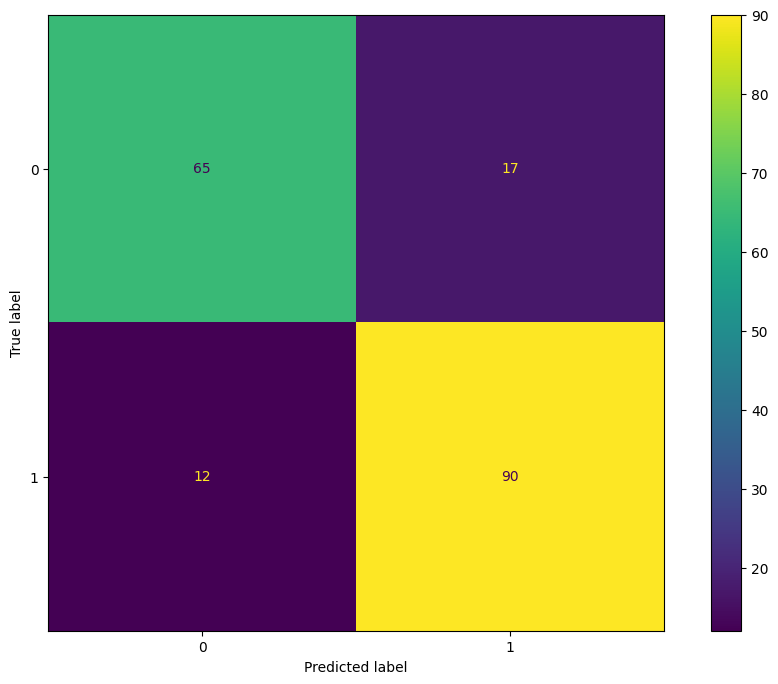

In [26]:
rf_best = rf_grid.best_estimator_
start_pred = time.time()

y_pred_rf_best = rf_best.predict(X_test)
end_pred = time.time()


print(f"Prediction time: {end_pred - start_pred:.2f} seconds")

print(classification_report(y_test, y_pred_rf_best,digits=4))
rf_best_report = classification_report(y_test, y_pred_rf_best, digits=4, output_dict=True)
rf_best_confm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_best)

## 4.4 XGBoost

Training time: 0.08 seconds
Prediction time: 0.01 seconds
XGBoost CLassification Report
              precision    recall  f1-score   support

           0     0.8514    0.7683    0.8077        82
           1     0.8273    0.8922    0.8585       102

    accuracy                         0.8370       184
   macro avg     0.8393    0.8302    0.8331       184
weighted avg     0.8380    0.8370    0.8359       184



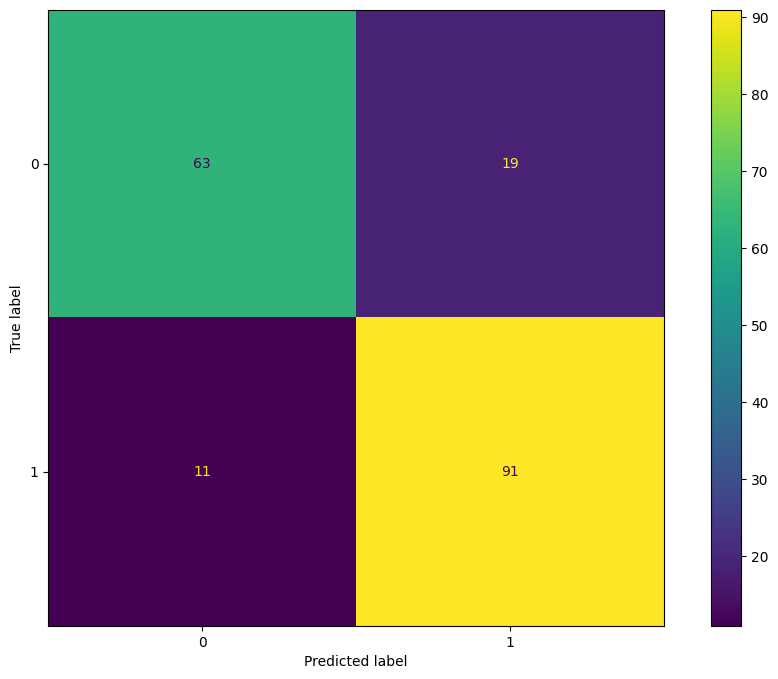

In [27]:
xgb = XGBClassifier(n_estimators=50, random_state=10)
start_fit = time.time()
xgb.fit(X_train, y_train)
end_fit = time.time()
xgb_fit_t = end_fit - start_fit
print(f"Training time: {end_fit - start_fit:.2f} seconds")

start_pred = time.time()
y_pred_xgb = xgb.predict(X_test)
end_pred = time.time()
print(f"Prediction time: {end_pred - start_pred:.2f} seconds")


print("XGBoost CLassification Report")
print(classification_report(y_test, y_pred_xgb, digits=4))
xgb_report = classification_report(y_test, y_pred_xgb, digits=4,output_dict=True)
xgb_confm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb)

## 4.5 XGBoost Hyperparameter Tuning

In [28]:
# Hyperparemters were are tuning
#(source: https://www.kaggle.com/code/abdmental01/heart-disease-prediction-binary-classification#Random-Forest )
params = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 1, 2]
}

xgb_grid = HalvingGridSearchCV(
    estimator=xgb,
    param_grid=params,
    cv=5,
    scoring='f1_macro',
    verbose=1,
    return_train_score=True,
    n_jobs=-1
)
start_fit = time.time()

xgb_grid.fit(X_train, y_train)
end_fit = time.time()
print(f"Training time: {end_fit - start_fit:.2f} seconds")

print("\nGrid Search Best Params:", xgb_grid.best_params_)

n_iterations: 4
n_required_iterations: 6
n_possible_iterations: 4
min_resources_: 20
max_resources_: 736
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 324
n_resources: 20
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
----------
iter: 1
n_candidates: 108
n_resources: 60
Fitting 5 folds for each of 108 candidates, totalling 540 fits
----------
iter: 2
n_candidates: 36
n_resources: 180
Fitting 5 folds for each of 36 candidates, totalling 180 fits
----------
iter: 3
n_candidates: 12
n_resources: 540
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training time: 35.83 seconds

Grid Search Best Params: {'colsample_bytree': 0.8, 'gamma': 2, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


Prediction time: 0.01 seconds
              precision    recall  f1-score   support

           0     0.8831    0.8293    0.8553        82
           1     0.8692    0.9118    0.8900       102

    accuracy                         0.8750       184
   macro avg     0.8761    0.8705    0.8726       184
weighted avg     0.8754    0.8750    0.8745       184



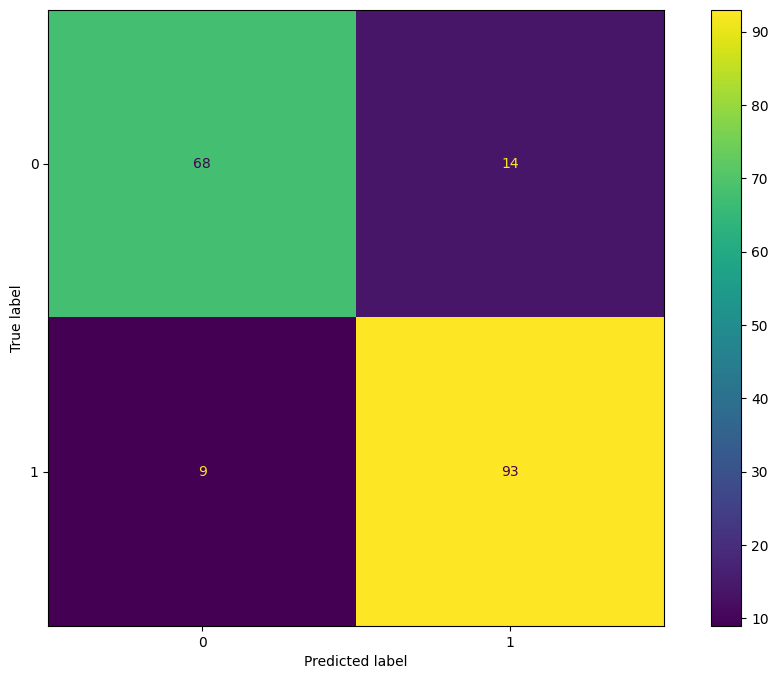

In [29]:
xgb_best = xgb_grid.best_estimator_
start_pred = time.time()

y_pred_xgb_best = xgb_best.predict(X_test)
end_pred = time.time()
xgb_best_pred_t = end_pred - start_pred

print(f"Prediction time: {end_pred - start_pred:.2f} seconds")
print(classification_report(y_test, y_pred_xgb_best, digits=4))
xgb_best_report = classification_report(y_test, y_pred_xgb_best, digits=4, output_dict=True)
xgb_best_confm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb_best)

# 5. Feature Analysis

## 5.1 Feature Analysis - Random Forest

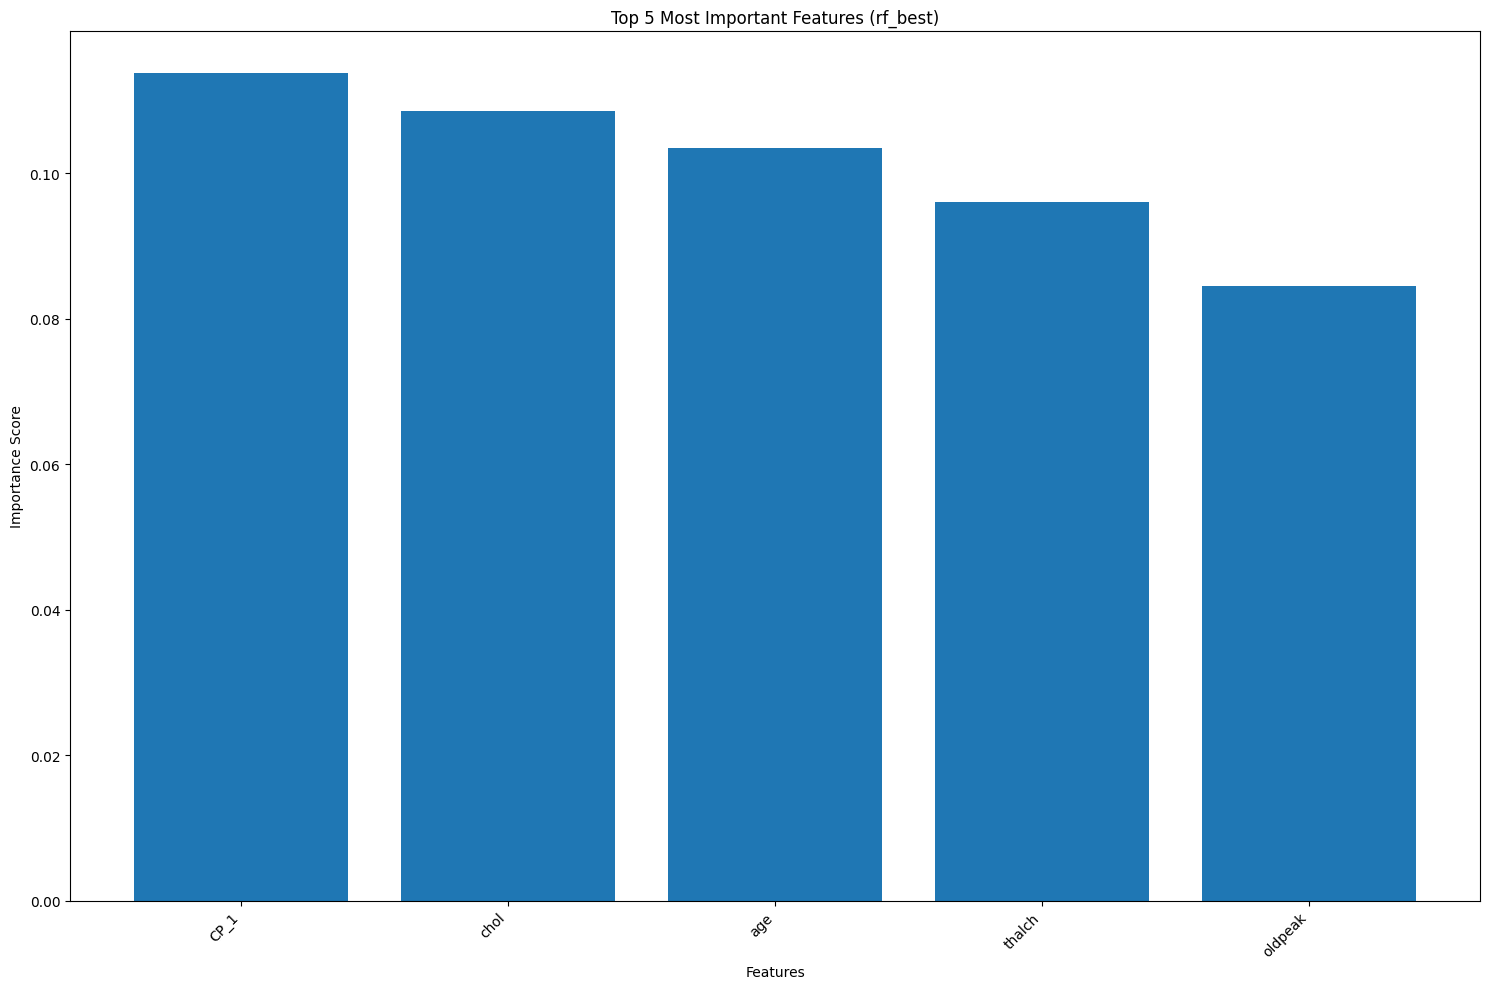


Top 5 Most Important Features:
 feature  importance
    CP_1    0.113855
    chol    0.108654
     age    0.103465
  thalch    0.096099
 oldpeak    0.084486
   exang    0.083927
trestbps    0.057148
    CP_3    0.055901
      ca    0.054871
    SL_1    0.034632
     sex    0.034004
    TH_2    0.024114
     fbs    0.023538
    TH_1    0.023125
 restecg    0.021008
    SL_3    0.019365
    CP_2    0.017407
    SL_2    0.011963
    TH_3    0.011619
    CP_0    0.008409
    TH_0    0.007776
    SL_0    0.004633


In [30]:
num_of_features = 5

importances = rf_best.feature_importances_
feature_names = X.columns

# contruct feature importance dataframe and sort it descending
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(15, 10))
plt.bar(range(num_of_features), feature_importance['importance'][:num_of_features])
plt.xticks(range(num_of_features), feature_importance['feature'][:num_of_features], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title(f'Top {num_of_features} Most Important Features (rf_best)')
plt.tight_layout()
plt.show()

print(f"\nTop {num_of_features} Most Important Features:")
print(feature_importance.to_string(index=False))

## 5.2 Feature Analysis - XGBoost

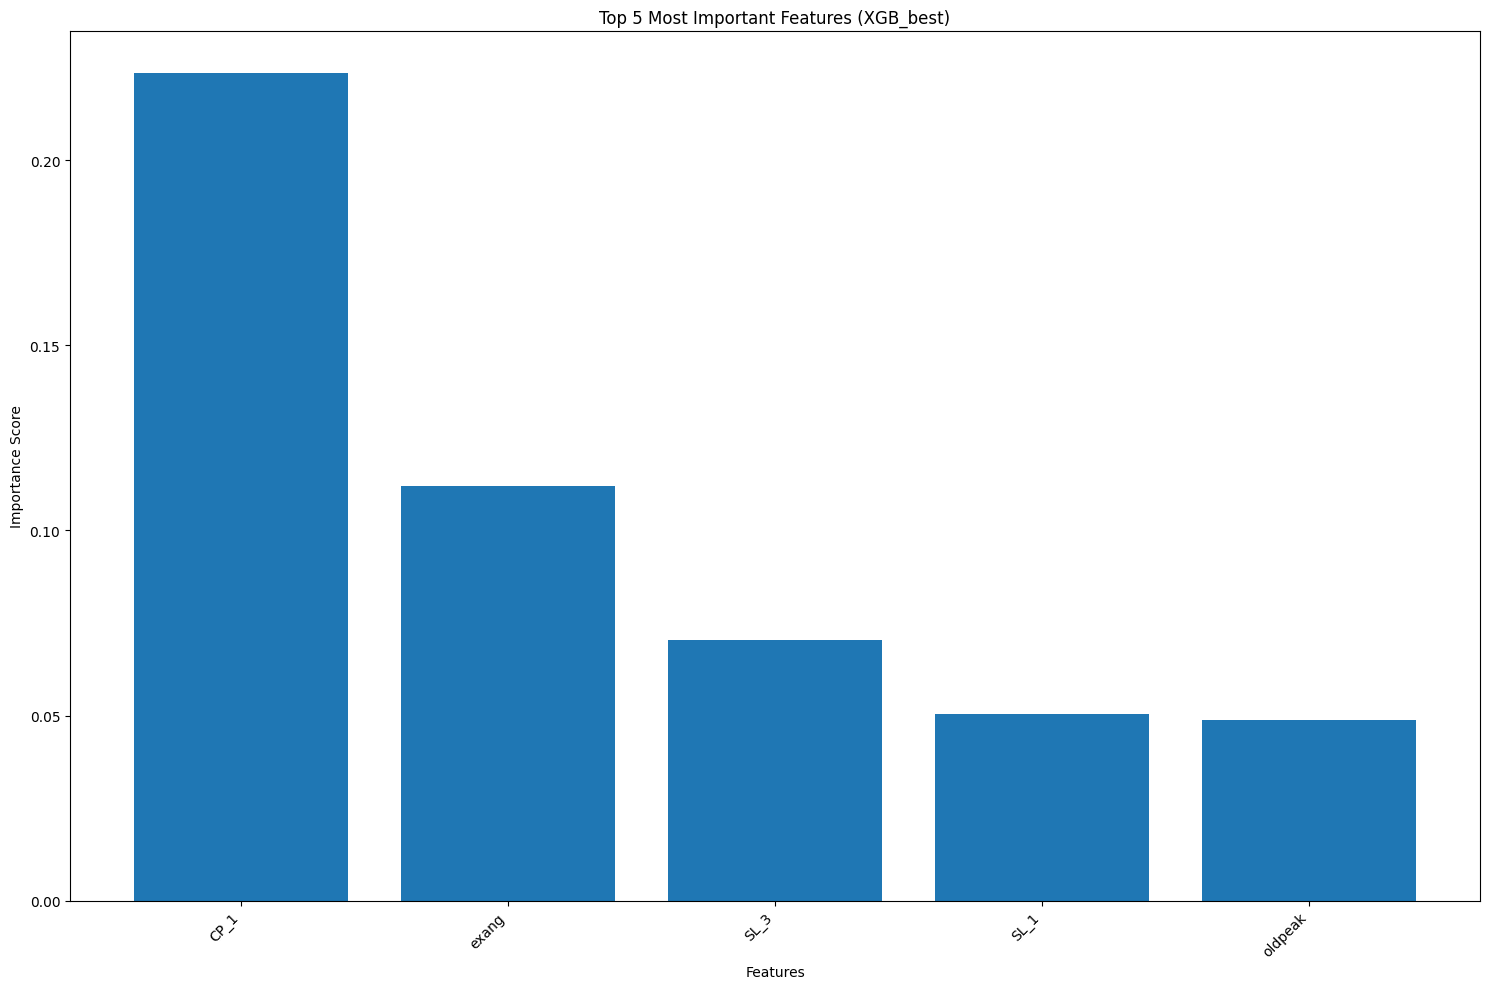


Top 5 Most Important Features:
 feature  importance
    CP_1    0.223642
   exang    0.111972
    SL_3    0.070443
    SL_1    0.050396
 oldpeak    0.048884
    TH_2    0.045777
    TH_3    0.045635
    CP_3    0.044755
      ca    0.043996
     age    0.036072
    chol    0.035657
     sex    0.034177
  thalch    0.032360
     fbs    0.032163
    TH_1    0.030289
    TH_0    0.023896
    SL_0    0.020174
 restecg    0.019954
trestbps    0.019406
    CP_2    0.015806
    SL_2    0.014546
    CP_0    0.000000


In [31]:
# Adjust here the number of features you want select  for later use
num_of_features = 5

importances = xgb_best.feature_importances_
feature_names = X.columns

# contruct featuere importance dataframe and sort it descending
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(15, 10))
plt.bar(range(num_of_features), feature_importance['importance'][:num_of_features])
plt.xticks(range(num_of_features), feature_importance['feature'][:num_of_features], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title(f'Top {num_of_features} Most Important Features (XGB_best)')
plt.tight_layout()
plt.show()

print(f"\nTop {num_of_features} Most Important Features:")
print(feature_importance.to_string(index=False))

## 5.1 Feature Analysis - ML Model Comparison

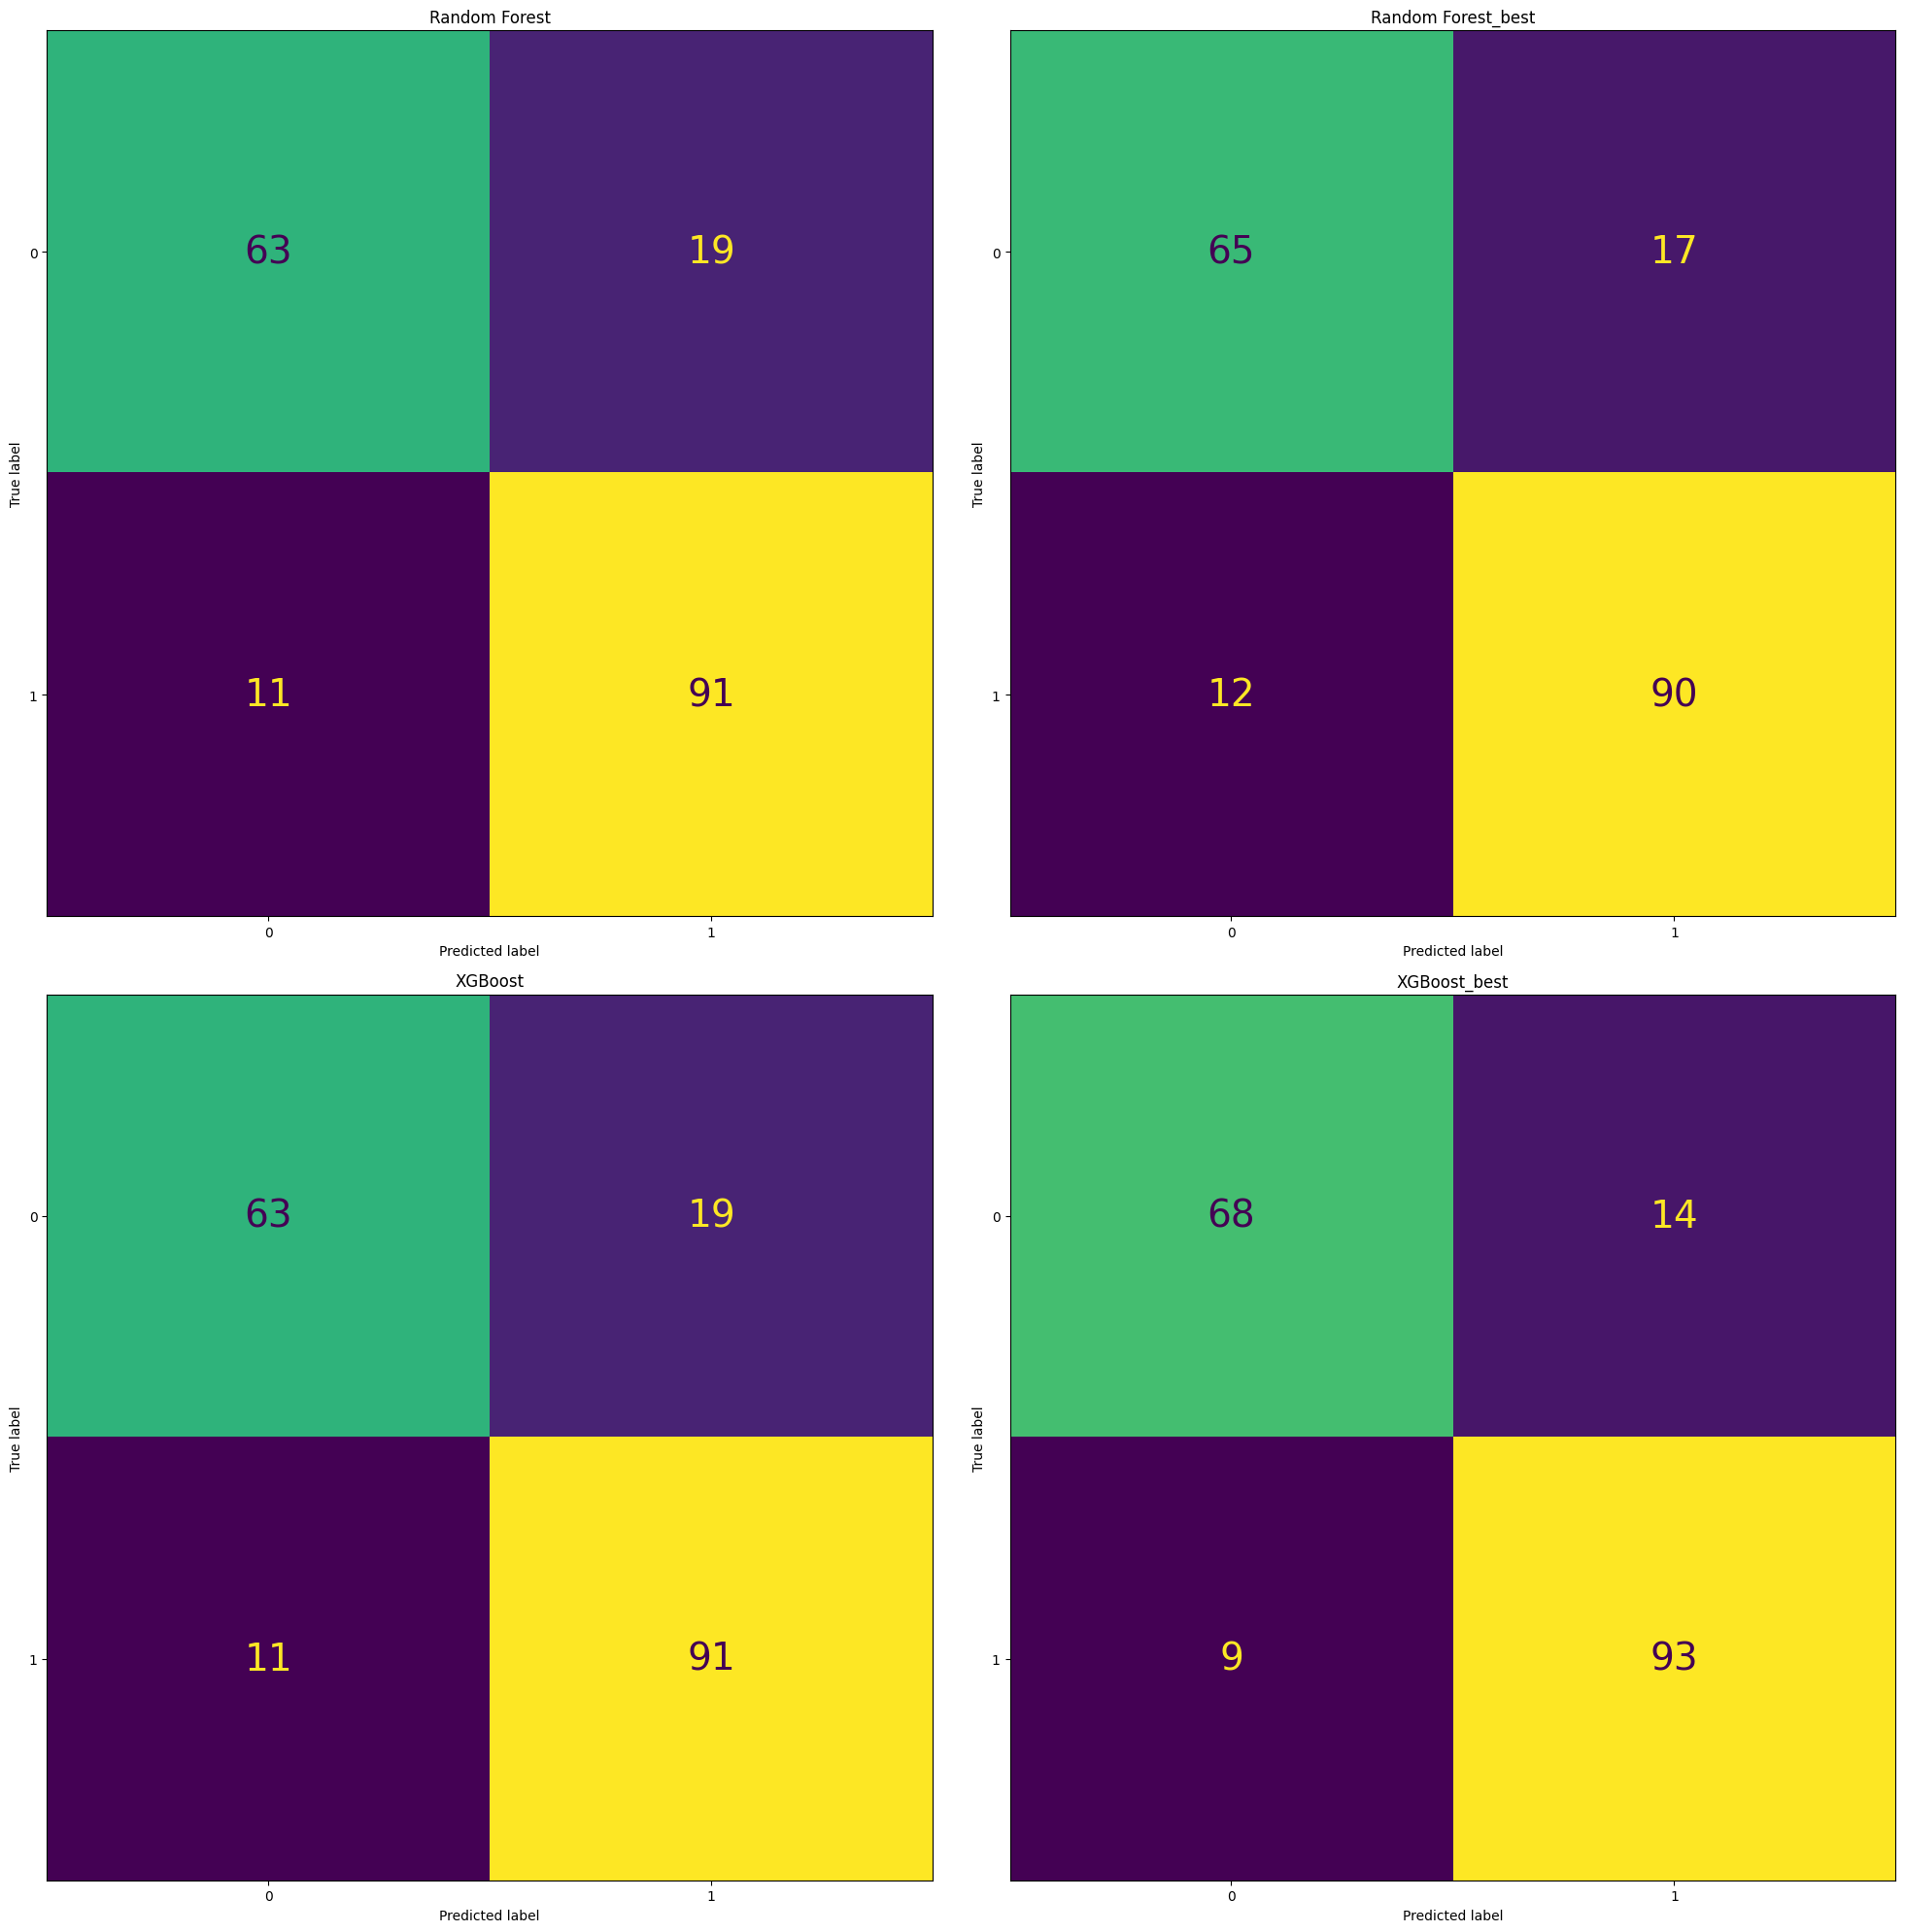

In [32]:
# Put all displays in a list and set titles
conf_displays = [rf_confm, rf_best_confm, xgb_confm, xgb_best_confm]

titles = ["Random Forest", "Random Forest_best", "XGBoost", "XGBoost_best"]

# Create a 4x1 grid
fig, axes = plt.subplots(2, 2, figsize=(20, 20)) 
axes = axes.flatten()

# Plot each confusion matrix display onto a different axis
for ax, display, title in zip(axes, conf_displays, titles):
    display.plot(ax=ax, colorbar=False)  # colorbar=False or True, as you prefer
    ax.set_title(title)

    for text in ax.texts:
        text.set_fontsize(28)

plt.tight_layout()
plt.show()

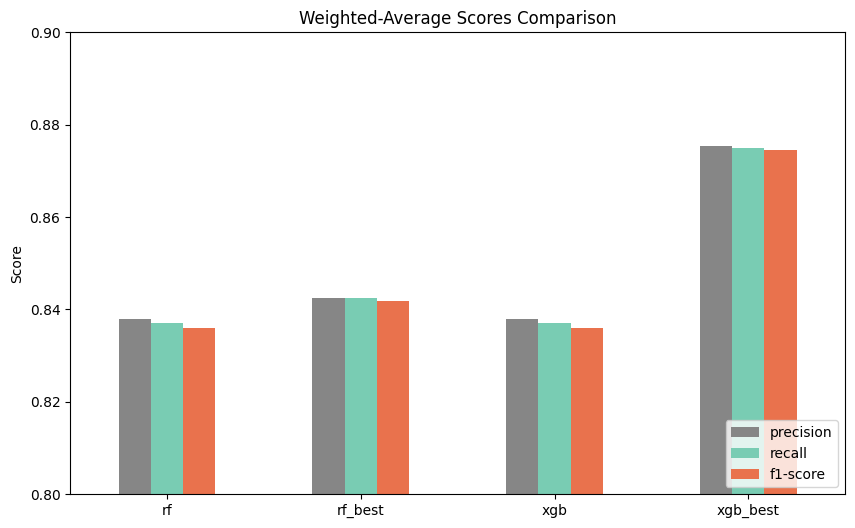

In [33]:
# -- The majority of this plotting code is written by ChatGPT --

# put all reports in a list
reports = [rf_report, rf_best_report, xgb_report, xgb_best_report]

model_names = [ "rf", "rf_best", "xgb", "xgb_best"]
# Initialize an empty DataFrame
comparison_df = pd.DataFrame(
    columns=["precision", "recall", "f1-score"], 
    index=model_names
)

for name, report in zip(model_names, reports):
    # 'macro avg' is a key in the dictionary
    weighted_avg = report["weighted avg"]
    comparison_df.loc[name, "precision"] = weighted_avg["precision"]
    comparison_df.loc[name, "recall"]    = weighted_avg["recall"]
    comparison_df.loc[name, "f1-score"]  = weighted_avg["f1-score"]


# https://www.color-hex.com/color-palette/18130
colors = ["#868686", "#79ccb3", "#e9724d"]


comparison_df.plot.bar(
    figsize=(10, 6), 
    color=colors
)
plt.title("Weighted-Average Scores Comparison")
plt.ylabel("Score")
plt.ylim([0.8, 0.9])
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()

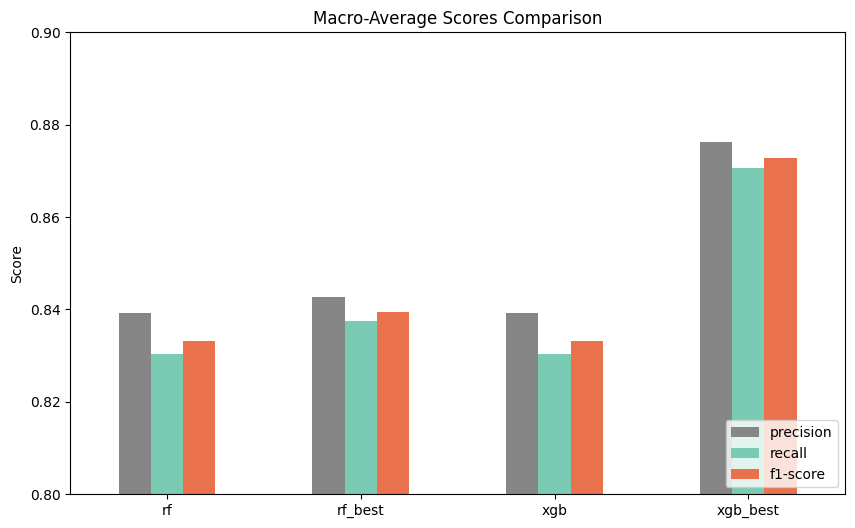

In [34]:
for name, report in zip(model_names, reports):
    macro_avg = report["macro avg"]
    comparison_df.loc[name, "precision"] = macro_avg["precision"]
    comparison_df.loc[name, "recall"]    = macro_avg["recall"]
    comparison_df.loc[name, "f1-score"]  = macro_avg["f1-score"]


comparison_df.plot.bar(
    figsize=(10, 6), 
    color=colors
)
plt.title("Macro-Average Scores Comparison")
plt.ylabel("Score")
plt.ylim([0.8, 0.9])
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()


# 6 Findings and Future Direction
## 6.1 Findings

The machine learning models did really well on the UCI heart disease dataset, with both Random Forest and XGBoost getting high accuracy scores of around 83-86%. But when we look at the project's features, we see that a few things hold it back from reaching better performance levels.

Sample Size: With 920 records, whilenormal for this type of analysis, it's still relatively small for complex machine learning models. Having more data could help spot subtle patterns and edge cases, which might improve how well it can classify things.


The hyperparameter-tuned models showed little improvements over the default ones, with the optimised XGBoost achieving an F1-macro score of 0.8558 compared to the baseline version that only gets 0.8394. This small improvement suggests that the default parameters were already a good fit for this medical dataset, or that the cross-validation approach used in hyperparameter tuning may have been more cautious to avoid overfitting.

The XGBoost models showed better computational efficiency, with training and prediction times that were faster than those of the Random Forest models. This makes them more suitable for real-time clinical applications. The feature importance analysis showed that chest pain type (cp), maximum heart rate achieved (thalach), and the number of major vessels (ca) were consistently the most predictive features across both algorithms, aligning with established cardiovascular risk factors in medical literature.

The binary classification approach (changing the original 0-4 scale to 0-1) worked well for making practical clinical decisions, with good specificity for identifying heart disease patients. The confusion matrix analysis showed that both models had acceptable false negative rates, which is obviously critical in medical diagnosis.

Using HalvingGridSearchCV was a great way to optimise the hyperparameters. It's worth comparing it with traditional GridSearchCV, as well as (off notebook), as it gives you some valuable insights into the trade-offs between computational efficiency and model performance. The engineered features (like age risk categories, blood pressure categories and heart rate fitness levels) were pretty linked to the target variable, which suggests that using domain knowledge to create features can improve how models are understood.


Reality: It's worth mentioning that 80-81% accuracy is actually pretty good for medical diagnosis. A lot of medical ML systems in the real world only hit 70-75% accuracy (increased to 85.13% in one study by adding psychological factors to the training data). [Link to source](https://www.sciencedirect.com/science/article/pii/S2772963X24004113)

## 6.2 Future Direction

### Further Research
1. Dataset Expansion: Validate on larger, more diverse patient populations
2. Feature Enhancement: Incorporate additional clinical variables and biomarkers
3. Multi-class Classification: Extend to predict specific types of heart disease

## 7. Limitations

### Dataset Limitations
1. Limited sample size did affect generalizability
2. Historical data may not reflect current clinical practices
3. Population demographics may not represent all patient groups

## 8. Conclusion

This project demonstrates the successful application of machine learning techniques to cardiovascular disease prediction. The developed models show promising performance for clinical decision support and with proper validation and implementation, these models can contribute to improved cardiovascular care and patient outcomes.

The comprehensive analysis provides a solid foundation for clinical implementation and future research, emphasizing the importance of rigorous methodology, clinical relevance, and practical considerations in medical ML applications.

### 8.1 Critics
The choice of the heart disease dataset was made  because the topic interests me personally. This helped with my motivation to work on this notebook but also had some downfalls. This dataset is way too complex for an introduction into machine learning. Trying to understand the inner workings of the algorithms used is impossible for me with my current knowledge in regards to this medical dataset. If I had chosen a simpler dataset for our work it would've been easier to understand what's actually happening. In addition it would've been possible to use better visualizations like actually printing one of the decision trees or displaying learning curves, which was not atainable due to the computational complexity of this heart disease prediction problem.

### 8.2 LLMS

ChatGPT 4o and Claude AI were used for helping with syntax erros and writing the code for the plots. It also helped clarifying terms and discussing ideas as well as helping with grammer and typos.

### 8.3 Literature

All of the Literature is linked directly when mentioned.